In [14]:
import os
import re
import warnings
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.svm import LinearSVC
from tqdm.auto import tqdm

# NLP imports (NLTK)
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

warnings.filterwarnings("ignore")

RANDOM_STATE = 42

In [15]:
def download_nltk_resources():
    try: nltk.data.find("tokenizers/punkt")
    except LookupError: nltk.download("punkt")

    try: nltk.data.find("corpora/stopwords")
    except LookupError: nltk.download("stopwords")

    try: nltk.data.find("corpora/wordnet")
    except LookupError: nltk.download("wordnet")

    try: nltk.data.find("taggers/averaged_perceptron_tagger")
    except LookupError: nltk.download("averaged_perceptron_tagger")

In [16]:

def download_nltk_resources():
    try: nltk.data.find("tokenizers/punkt")
    except LookupError: nltk.download("punkt")

    try: nltk.data.find("corpora/stopwords")
    except LookupError: nltk.download("stopwords")

    try: nltk.data.find("corpora/wordnet")
    except LookupError: nltk.download("wordnet")

    try: nltk.data.find("taggers/averaged_perceptron_tagger")
    except LookupError: nltk.download("averaged_perceptron_tagger")


def simple_preprocess(text, lemmatizer=None, stop_words=None):
    if not isinstance(text, str):
        return ""

    text = text.lower()
    text = re.sub(r"https?://\S+|www\.\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#", "", text)
    text = re.sub(r"[^a-z0-9\s]", " ", text)

    tokens = word_tokenize(text)
    if stop_words is None:
        stop_words = set()
    tokens = [t for t in tokens if t not in stop_words and len(t) > 1]

    if lemmatizer is not None:
        tokens = [lemmatizer.lemmatize(t) for t in tokens]

    return " ".join(tokens)

###########################################################
# ↓   MAIN PIPELINE FUNCTION (complete training for dataset)
###########################################################

def run_full_training_pipeline(DATA_PATH, OUTPUT_PREFIX):
    print("\n" + "="*80)
    print(f"▶ TRAINING ON DATASET: {DATA_PATH}")
    print("="*80)

    download_nltk_resources()
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words("english"))

    if not os.path.exists(DATA_PATH):
        raise FileNotFoundError(f"Dataset not found: {DATA_PATH}")

    df = pd.read_csv(DATA_PATH)
    print(f"Loaded {len(df)} rows. Columns: {df.columns.tolist()}")

    TEXT_COL = None
    for col in ["text", "tweet", "content", "message"]:
        if col in df.columns: TEXT_COL = col; break
    if TEXT_COL is None:
        TEXT_COL = next((c for c in df.columns if df[c].dtype == object), None)

    TARGET_COL = None
    for col in ["label", "sentiment", "target", "class"]:
        if col in df.columns: TARGET_COL = col; break
    if TARGET_COL is None:
        for c in df.columns:
            if c != TEXT_COL and df[c].nunique() <= 10:
                TARGET_COL = c
                break

    if TEXT_COL is None or TARGET_COL is None:
        raise ValueError(f"Couldn’t locate TEXT/TARGET column in {DATA_PATH}")

    print(f"Using text column:   {TEXT_COL}")
    print(f"Using target column: {TARGET_COL}")

    df = df.dropna(subset=[TEXT_COL, TARGET_COL]).reset_index(drop=True)

    tqdm.pandas(desc="Preprocessing text")
    df["cleaned_text"] = df[TEXT_COL].progress_apply(
        lambda t: simple_preprocess(t, lemmatizer, stop_words)
    )

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df[TARGET_COL])
    X = df["cleaned_text"].values

    classes = label_encoder.classes_
    print(f"Detected classes: {list(classes)}")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2,
        random_state=RANDOM_STATE,
        stratify=y if len(np.unique(y)) > 1 else None
    )

    pipelines = {
        "LogisticRegression": Pipeline([
            ("tfidf", TfidfVectorizer(max_features=20000, ngram_range=(1, 2)) ),
            ("clf", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)),
        ]),
        "LinearSVC": Pipeline([
            ("tfidf", TfidfVectorizer(max_features=20000, ngram_range=(1, 2)) ),
            ("clf", LinearSVC(random_state=RANDOM_STATE)),
        ]),
        "MultinomialNB": Pipeline([
            ("tfidf", TfidfVectorizer(max_features=20000, ngram_range=(1, 2)) ),
            ("clf", MultinomialNB()),
        ]),
        "RandomForest": Pipeline([
            ("tfidf", TfidfVectorizer(max_features=20000, ngram_range=(1, 2)) ),
            ("clf", __import__("sklearn.ensemble").ensemble.RandomForestClassifier(
                    n_estimators=300, random_state=RANDOM_STATE)),
        ]),
    }

    results = []
    trained = {}

    for name, pipe in pipelines.items():
        print(f"\nTraining {name} on {DATA_PATH} ...")
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        y_proba = None
        if hasattr(pipe.named_steps["clf"], "predict_proba"):
            y_proba = pipe.predict_proba(X_test)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average="weighted")
        prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
        rec = recall_score(y_test, y_pred, average="weighted", zero_division=0)

        roc = None
        try:
            if y_proba is not None:
                lb = LabelBinarizer()
                y_test_b = lb.fit_transform(y_test)
                roc = roc_auc_score(y_test_b, y_proba, average="weighted", multi_class="ovr")
        except:
            roc = None

        results.append({
            "Model": name,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1 Score": f1,
            "ROC-AUC": roc,
        })

        trained[name] = pipe

    results_df = pd.DataFrame(results).sort_values(
        by="F1 Score", ascending=False
    ).reset_index(drop=True)

    print("\n\n===== RESULTS FOR DATASET:", DATA_PATH, "=====")
    print(results_df)

    plt.figure(figsize=(8, 4))
    sns.barplot(data=results_df, x="F1 Score", y="Model")
    plt.title(f"Model Comparison - {OUTPUT_PREFIX}")
    plt.tight_layout()
    plt.show()

    best_model_name = results_df.iloc[0]["Model"]
    best_model = trained[best_model_name]
    output_filename = f"{OUTPUT_PREFIX}_best_model.joblib"

    joblib.dump({"pipeline": best_model, "label_encoder": label_encoder}, output_filename)
    print(f"\nSaved best model → {output_filename}")

    y_pred = best_model.predict(X_test)
    print("\nClassification Report:\n")
    print(classification_report(
        y_test, y_pred, target_names=[str(c) for c in classes]
    ))

    # --------------- RETURN BLOCK ------------------
    return {
        "X_test": X_test,
        "y_test": y_test,
        "results_df": results_df,
        "trained_models": trained,
        "best_model": best_model,
        "classes": classes
    }


In [17]:
from google.colab import files
uploaded = files.upload()


Saving depression_dataset_reddit_cleaned.csv to depression_dataset_reddit_cleaned (1).csv
Saving Twitter_Data.csv to Twitter_Data (1).csv


In [18]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')      # <-- NEW REQUIRED RESOURCE


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True


▶ TRAINING ON DATASET: Twitter_Data.csv


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Loaded 162980 rows. Columns: ['clean_text', 'category']
Using text column:   clean_text
Using target column: category


Preprocessing text:   0%|          | 0/162969 [00:00<?, ?it/s]

Detected classes: [np.float64(-1.0), np.float64(0.0), np.float64(1.0)]

Training LogisticRegression on Twitter_Data.csv ...

Training LinearSVC on Twitter_Data.csv ...

Training MultinomialNB on Twitter_Data.csv ...

Training RandomForest on Twitter_Data.csv ...


===== RESULTS FOR DATASET: Twitter_Data.csv =====
                Model  Accuracy  Precision    Recall  F1 Score   ROC-AUC
0           LinearSVC  0.893907   0.894137  0.893907  0.893160       NaN
1  LogisticRegression  0.878812   0.880048  0.878812  0.877341  0.959915
2        RandomForest  0.849758   0.851042  0.849758  0.845940  0.951594
3       MultinomialNB  0.726637   0.744971  0.726637  0.718084  0.899417


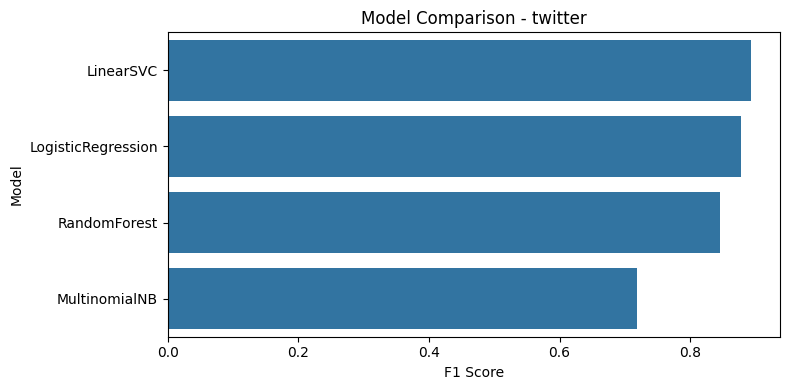


Saved best model → twitter_best_model.joblib

Classification Report:

              precision    recall  f1-score   support

        -1.0       0.87      0.80      0.83      7102
         0.0       0.88      0.95      0.91     11042
         1.0       0.92      0.90      0.91     14450

    accuracy                           0.89     32594
   macro avg       0.89      0.88      0.88     32594
weighted avg       0.89      0.89      0.89     32594


▶ TRAINING ON DATASET: depression_dataset_reddit_cleaned.csv
Loaded 7731 rows. Columns: ['clean_text', 'is_depression']
Using text column:   clean_text
Using target column: is_depression


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Preprocessing text:   0%|          | 0/7731 [00:00<?, ?it/s]

Detected classes: [np.int64(0), np.int64(1)]

Training LogisticRegression on depression_dataset_reddit_cleaned.csv ...

Training LinearSVC on depression_dataset_reddit_cleaned.csv ...

Training MultinomialNB on depression_dataset_reddit_cleaned.csv ...

Training RandomForest on depression_dataset_reddit_cleaned.csv ...


===== RESULTS FOR DATASET: depression_dataset_reddit_cleaned.csv =====
                Model  Accuracy  Precision    Recall  F1 Score ROC-AUC
0           LinearSVC  0.963801   0.963993  0.963801  0.963794    None
1  LogisticRegression  0.959922   0.960432  0.959922  0.959905    None
2        RandomForest  0.957983   0.960461  0.957983  0.957913    None
3       MultinomialNB  0.886231   0.903641  0.886231  0.885103    None


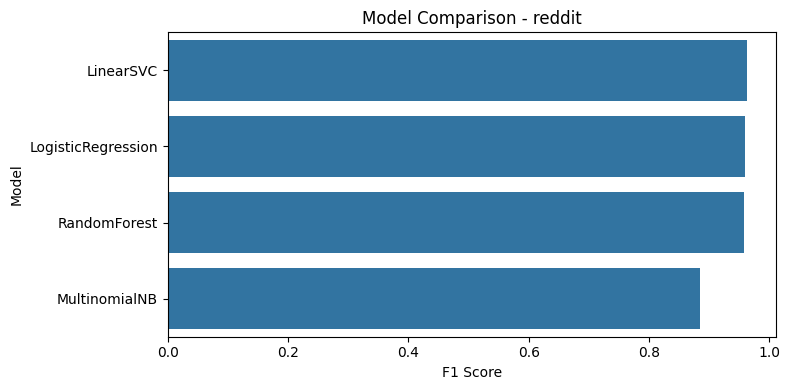


Saved best model → reddit_best_model.joblib

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       780
           1       0.97      0.95      0.96       767

    accuracy                           0.96      1547
   macro avg       0.96      0.96      0.96      1547
weighted avg       0.96      0.96      0.96      1547



In [19]:
twitter_results = run_full_training_pipeline("Twitter_Data.csv", "twitter")
reddit_results  = run_full_training_pipeline("depression_dataset_reddit_cleaned.csv", "reddit")


In [20]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, classes, title, filename, fmt="d"):
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt=fmt,
        cmap="Blues",
        xticklabels=classes,
        yticklabels=classes
    )
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(filename, dpi=150)
    plt.show()


In [21]:
def generate_confusion_matrices(results, prefix):
    X_test   = results["X_test"]
    y_test   = results["y_test"]
    classes  = results["classes"]
    models   = results["trained_models"]   # ALL 4 MODELS

    for model_name, model in models.items():
        print(f"\n===== {prefix.upper()} — {model_name} =====")

        # Get predictions
        y_pred = model.predict(X_test)

        # Raw confusion matrix
        cm = confusion_matrix(y_test, y_pred)

        plot_confusion_matrix(
            cm,
            classes,
            title=f"{prefix} - {model_name} (Counts)",
            filename=f"{prefix}_{model_name}_cm_counts.png",
            fmt="d"
        )

        # Normalized confusion matrix
        cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

        plot_confusion_matrix(
            cm_norm,
            classes,
            title=f"{prefix} - {model_name} (Normalized)",
            filename=f"{prefix}_{model_name}_cm_normalized.png",
            fmt=".2f"
        )



===== TWITTER — LogisticRegression =====


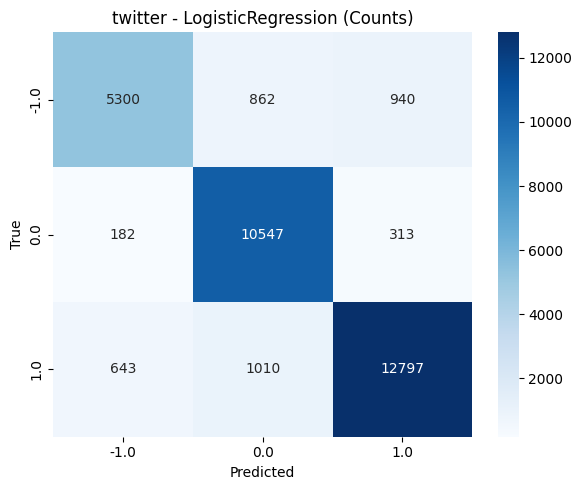

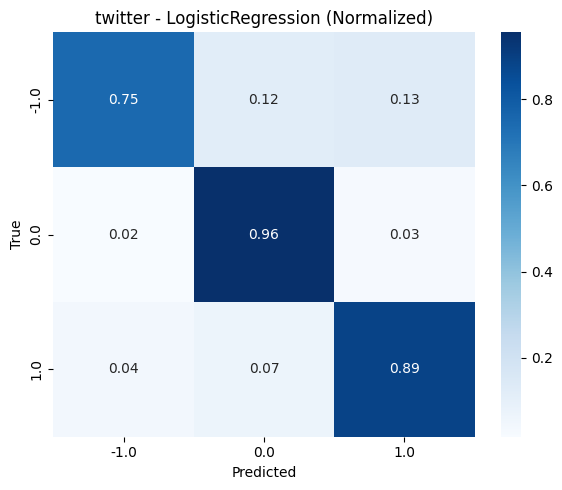


===== TWITTER — LinearSVC =====


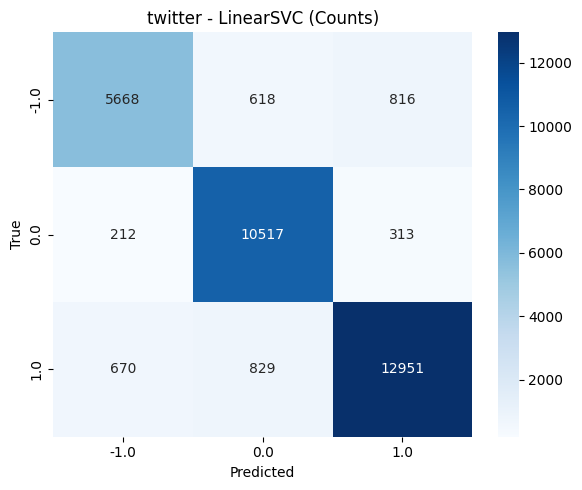

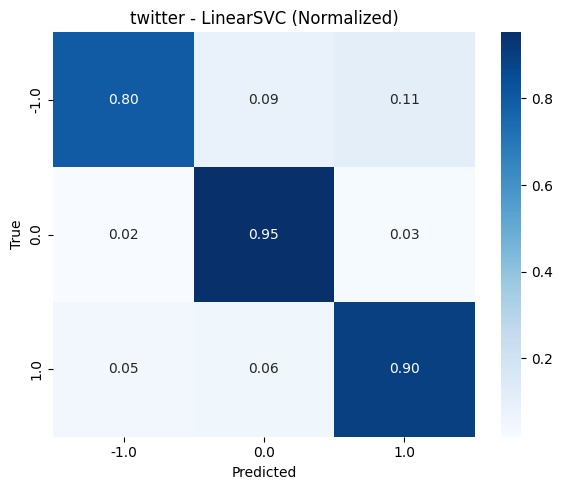


===== TWITTER — MultinomialNB =====


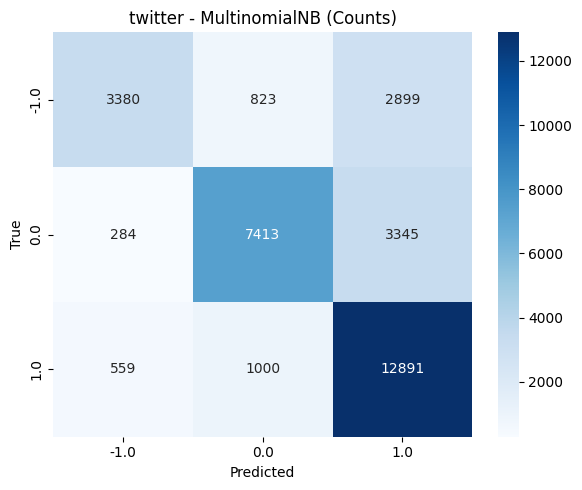

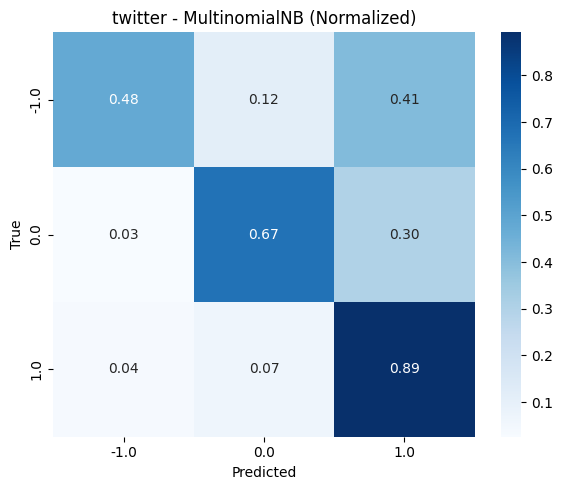


===== TWITTER — RandomForest =====


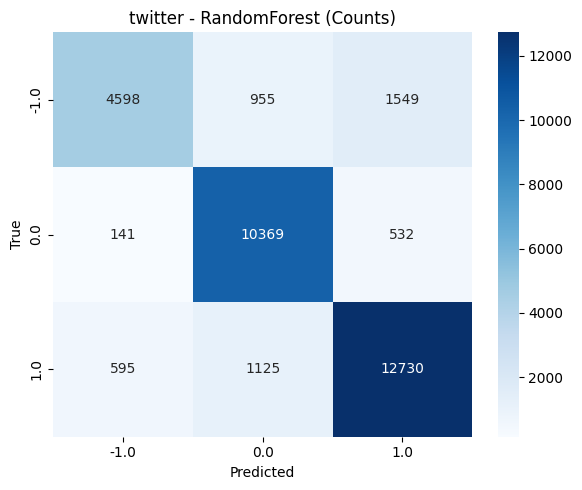

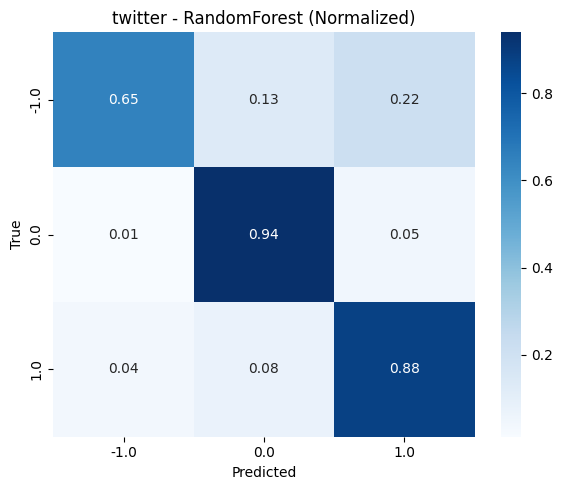


===== REDDIT — LogisticRegression =====


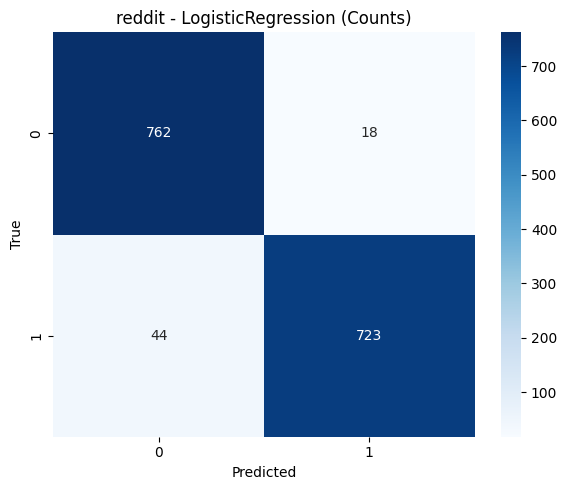

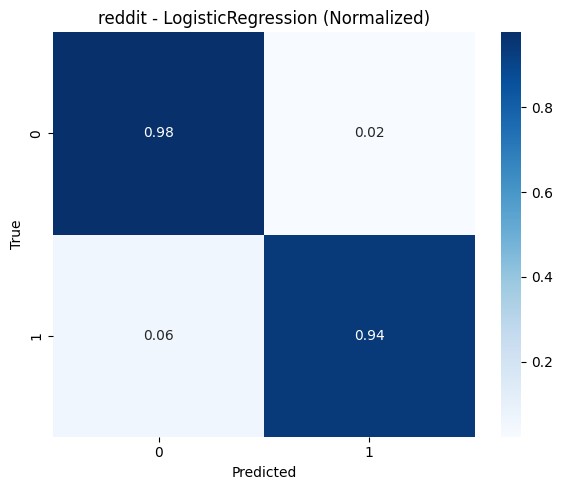


===== REDDIT — LinearSVC =====


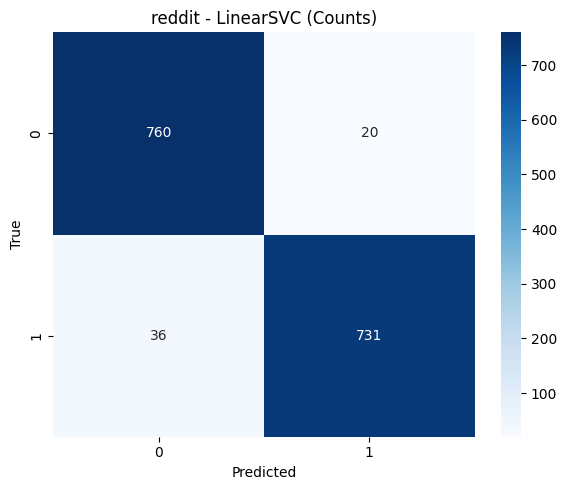

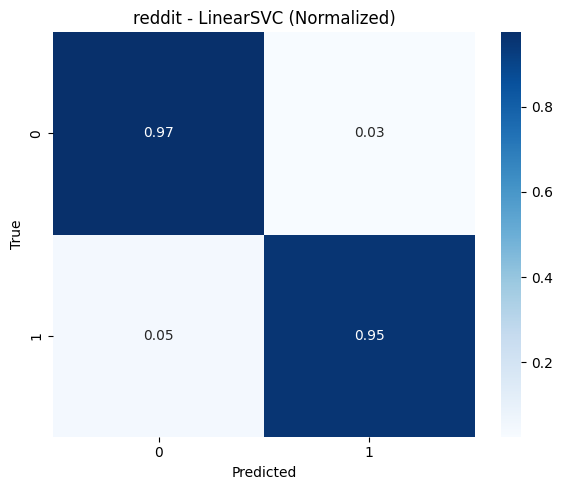


===== REDDIT — MultinomialNB =====


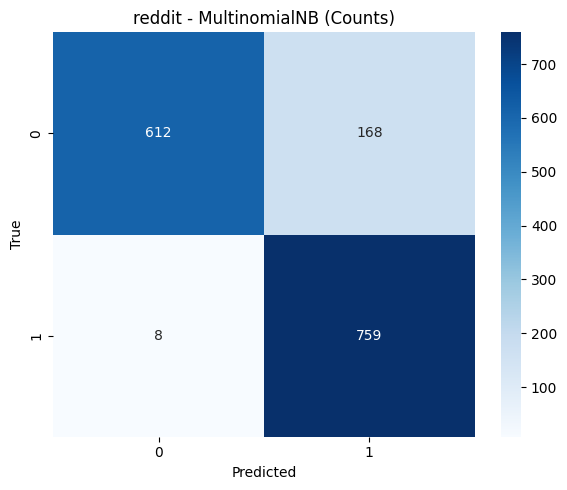

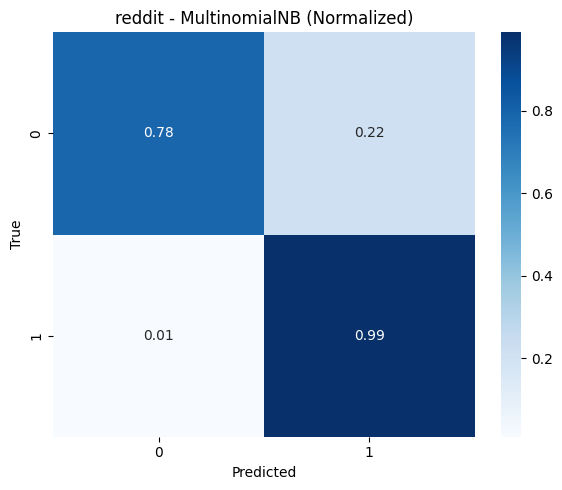


===== REDDIT — RandomForest =====


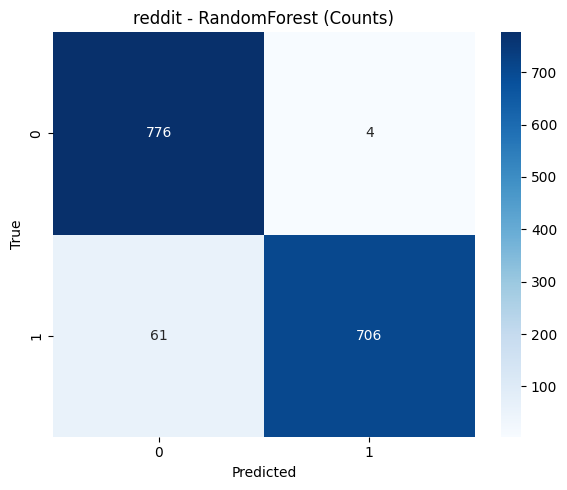

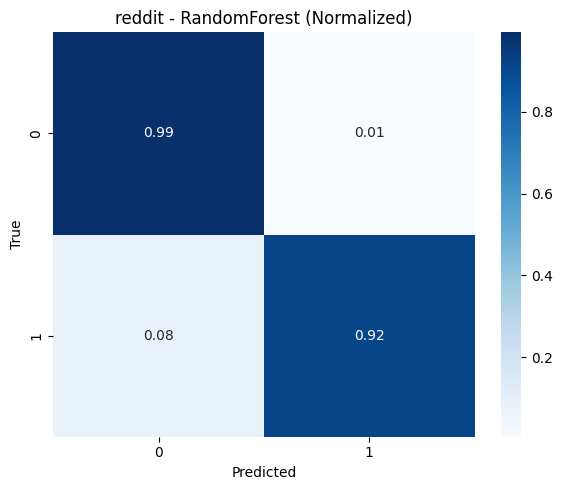

In [22]:
generate_confusion_matrices(twitter_results, "twitter")
generate_confusion_matrices(reddit_results, "reddit")


In [23]:
!sudo apt-get install tesseract-ocr
!pip install pytesseract


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [24]:
import pytesseract
from PIL import Image
import traceback
import numpy as np

# Sentiment labels you want returned
SENTIMENT_MAP = {
    -1: "Negative",
     0: "Neutral",
     1: "Positive",
     2: "Positive"   # if dataset uses 2 for positive
}

def safe_load_results(name):
    # 1. Try in-memory variables first
    try:
        info = globals()[f"{name}_results"]

        # Ensure label_encoder key exists
        if "label_encoder" not in info:
            raise KeyError("label_encoder missing from results")

        return info
    except Exception:
        pass

    # 2. Try loading best model from disk
    try:
        saved = joblib.load(f"{name}_best_model.joblib")

        pipeline = saved.get("pipeline")
        le = saved.get("label_encoder")

        return {
            "trained_models": {"Best": pipeline},
            "best_model": pipeline,
            "classes": list(le.classes_) if le else None,
            "label_encoder": le,
            "X_test": None,
            "y_test": None,
            "results_df": None
        }
    except Exception:
        return None


twitter_info = safe_load_results("twitter")
reddit_info  = safe_load_results("reddit")

dataset_options = []
if twitter_info: dataset_options.append("Twitter")
if reddit_info:  dataset_options.append("Reddit")

if not dataset_options:
    raise RuntimeError("No datasets found. Train first.")

# ----------------------------
# Probability helpers
# ----------------------------
def decision_to_proba(dfc):
    dfc = np.array(dfc)
    if dfc.ndim == 1:
        from scipy.special import expit
        p1 = expit(dfc)
        p0 = 1 - p1
        return np.vstack([p0, p1]).T
    expd = np.exp(dfc - np.max(dfc, axis=1, keepdims=True))
    return expd / np.sum(expd, axis=1, keepdims=True)

def get_proba_from_pipeline(pipe, texts):
    try:
        if hasattr(pipe.named_steps["clf"], "predict_proba"):
            return pipe.predict_proba(texts)
        if hasattr(pipe.named_steps["clf"], "decision_function"):
            dfc = pipe.decision_function(texts)
            return decision_to_proba(dfc)
    except:
        return None
    return None

# ----------------------------
# Ensemble helper
# ----------------------------
def ensemble_avg_proba(info, texts):
    proba_list = []
    classes = info["classes"]

    for name, pipe in info["trained_models"].items():
        try:
            p = get_proba_from_pipeline(pipe, texts)
            if p is None:
                preds = pipe.predict(texts)
                onehot = np.zeros((len(preds), len(classes)))
                for i, pred in enumerate(preds):
                    onehot[i, pred] = 1.0
                p = onehot

            if p.shape[1] != len(classes):
                pad = np.zeros((p.shape[0], len(classes)-p.shape[1]))
                p = np.hstack([p, pad])

            proba_list.append(p)
        except:
            continue

    if not proba_list:
        return None

    stacked = np.stack(proba_list, axis=0)
    return stacked.mean(axis=0)

# ----------------------------
# OCR helper
# ----------------------------
def extract_text_from_image(image):
    if image is None:
        return ""
    try:
        pil_img = Image.fromarray(image)
        text = pytesseract.image_to_string(pil_img)
        return text.strip()
    except:
        return ""

# ----------------------------
# PREDICTION FUNCTION
# ----------------------------
def predict_interface(dataset_choice, model_choice, text, image):
    try:
        info = twitter_info if dataset_choice == "Twitter" else reddit_info
        if info is None:
            return {"error": "Dataset not loaded."}

        le = info["label_encoder"]

        # If image uploaded → override text
        if image is not None:
            extracted = extract_text_from_image(image)
            if extracted.strip():
                text = extracted

        if not text.strip():
            return {"error": "No text found in input or image."}

        cleaned = simple_preprocess(
            text,
            WordNetLemmatizer(),
            set(stopwords.words("english"))
        )

        # Output formatter
        def build_output(model_name, idx, conf):
            orig = le.inverse_transform([idx])[0]
            sentiment = SENTIMENT_MAP.get(orig, str(orig))
            return {
                "best_model": model_name,
                "sentiment": sentiment,
                "confidence": conf,
                "extracted_text": text
            }

        # ----- BEST MODEL -----
        if model_choice == "Best":
            pipe = info["best_model"]
            proba = get_proba_from_pipeline(pipe, [cleaned])

            if proba is not None:
                idx = int(np.argmax(proba))
                conf = float(np.max(proba))
            else:
                idx = int(pipe.predict([cleaned])[0])
                conf = None

            return build_output(f"Best-{dataset_choice}", idx, conf)

        # ----- ENSEMBLE -----
        if model_choice == "Ensemble":
            proba = ensemble_avg_proba(info, [cleaned])
            idx = int(np.argmax(proba))
            conf = float(np.max(proba))
            return build_output(f"Ensemble-{dataset_choice}", idx, conf)

        # ----- SPECIFIC MODEL -----
        chosen_key = None
        for k in info["trained_models"]:
            if model_choice.lower() in k.lower():
                chosen_key = k
                break
        if chosen_key is None:
            chosen_key = list(info["trained_models"].keys())[0]

        pipe = info["trained_models"][chosen_key]
        proba = get_proba_from_pipeline(pipe, [cleaned])

        if proba is not None:
            idx = int(np.argmax(proba))
            conf = float(np.max(proba))
        else:
            idx = int(pipe.predict([cleaned])[0])
            conf = None

        return build_output(chosen_key, idx, conf)

    except Exception as e:
        return {"error": str(e), "trace": traceback.format_exc()}

# ----------------------------
# Build model list for dropdown
# ----------------------------
model_set = set()

for info in [twitter_info, reddit_info]:
    if info:
        model_set.update(info["trained_models"].keys())

canonical = ["LogisticRegression", "LinearSVC", "MultinomialNB", "RandomForest"]
for m in canonical:
    model_set.add(m)

model_options = sorted(model_set) + ["Best", "Ensemble"]

# ----------------------------
# GRADIO UI
# ----------------------------
import gradio as gr

demo = gr.Interface(
    fn=predict_interface,
    inputs=[
        gr.Dropdown(dataset_options, label="Dataset"),
        gr.Dropdown(model_options, label="Model", value="Best"),
        gr.Textbox(lines=3, placeholder="Type text to analyze (optional)"),
        gr.Image(type="numpy", label="Upload Image (optional)")
    ],
    outputs=[gr.JSON(label="Prediction")],
    title="Unified Sentiment Predictor (Text + Image OCR)",
    description="Upload an image OR type text. Choose dataset and model."
)

demo.launch(share=True, debug=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://1f5594acd49919428f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1134, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://009c97a54e69116038.gradio.live
Killing tunnel 127.0.0.1:7860 <> https://1f5594acd49919428f.gradio.live
